# <center> Building a Phishing Email Model

### Table of Contents

1. [Objective](#1)
2. [Import the required libraries](#2)
3. [Data Preparation](#3)
4. [Data Preprocessing](#4)
5. [Feature Extraction](#5)
6. [Model Training and Evaluation](#6)
7. [Report the result](#7)

<a name='1'></a>
### 1. [Objective](#1)
Build a machine learning model to detect phishing attacks using a dataset of emails and URLs.

<a name='4'></a>
### 2. [Import the required libraries](#2)

In [1]:
import pandas as pd
import numpy as nm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
snowball_stemmer = SnowballStemmer("english")
porter_stemmer = PorterStemmer()
stop_words=stopwords.words("english")

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rajeev.v\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rajeev.v\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<a name='3'></a>
### 3. [Data Preparation](#3)

In [2]:
# Load the dataset into a pandas DataFrame
data = pd.read_csv("email_dataset.csv")

In [3]:
# Display the first few rows of the dataset to get an overview
data.head(5)

Text  Class
0  Supply Quality China's EXCLUSIVE dimensions at...      1
1                         over. SidLet me know. Thx.      0
2  Dear Friend,Greetings to you.I wish to accost ...      1
3  MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....      1
4          Not a surprising assessment from Embassy.      0

In [4]:
# Get the shape of the dataset (number of rows and columns)
print("Dataset shape:", data.shape)

Dataset shape: (11929, 2)


In [5]:
# Get the column names (features)
print("Column names:", data.columns)

Column names: Index(['Text', 'Class'], dtype='object')


In [6]:
data['Class'].value_counts()

Class
0    6742
1    5187
Name: count, dtype: int64

<a name='4'></a>
### 4. [Data Preprocessing](#4)

In [7]:
# Check for missing values
data.isnull().sum()

Text     1
Class    0
dtype: int64

In [8]:
# Drop rows with missing values from Text
data.dropna(subset=['Text'], inplace=True)

In [9]:
# Check for missing values after missing text droping
data.isnull().sum()

Text     0
Class    0
dtype: int64

In [13]:
# Check for duplicates records in dataset
duplicates = data.duplicated()

# Count the number of duplicate records
num_duplicates = duplicates.sum()

print("Number of duplicate records:", num_duplicates)

Number of duplicate records: 1679


In [14]:
# Let us drop the index column because that acts as a primary key and has no significance in EDA and modelling
data = data.drop_duplicates(keep='first')

In [15]:
# word count
data['word_count'] = data['Text'].apply(lambda x: len(str(x).split(" ")))
data[['Text','word_count']].head()

Text  word_count
0  Supply Quality China's EXCLUSIVE dimensions at...         171
1                         over. SidLet me know. Thx.           5
2  Dear Friend,Greetings to you.I wish to accost ...         397
3  MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....         612
4          Not a surprising assessment from Embassy.           6

In [16]:
# Get summary statistics of word count
data.word_count.describe()

count    10249.000000
mean       198.638892
std        388.017301
min          1.000000
25%         13.000000
50%         46.000000
75%        338.000000
max      11936.000000
Name: word_count, dtype: float64

In [17]:
# data cleaning
# remove punchuation marks
def dataClean(Text):
    message = re.sub('[^a-zA-Z]', ' ', Text)
    message = message.split()
    return " ".join(message)

data['Text'] = data['Text'].apply(dataClean)
print(data.head(n=10))

                                                Text  Class  word_count
0  Supply Quality China s EXCLUSIVE dimensions at...      1         171
1                            over SidLet me know Thx      0           5
2  Dear Friend Greetings to you I wish to accost ...      1         397
3  MR CHEUNG PUIHANG SENG BANK LTD DES VOEUX RD B...      1         612
4           Not a surprising assessment from Embassy      0           6
5  Monica Huma Abedin Huma clintonemail com Tuesd...      0          22
6  Pis print H hrod clintonemail com Thursday Oct...      0          12
7  Dear Tom H hrod clintonemail com Friday Decemb...      0          63
8  Greetings from barrister Robert Williams CDear...      1         595
9  FYI Thanks again for signing the book and I do...      0          29


In [18]:
# Convert to lower
def lowercase(Text):
    message = Text.lower()
    return message

data['Text'] = data['Text'].apply(lowercase)
data.head(n = 10)

Text  Class  word_count
0  supply quality china s exclusive dimensions at...      1         171
1                            over sidlet me know thx      0           5
2  dear friend greetings to you i wish to accost ...      1         397
3  mr cheung puihang seng bank ltd des voeux rd b...      1         612
4           not a surprising assessment from embassy      0           6
5  monica huma abedin huma clintonemail com tuesd...      0          22
6  pis print h hrod clintonemail com thursday oct...      0          12
7  dear tom h hrod clintonemail com friday decemb...      0          63
8  greetings from barrister robert williams cdear...      1         595
9  fyi thanks again for signing the book and i do...      0          29

<a name='5'></a>
### 5. [Feature Extraction](#5)

In [19]:
# Stemming and lemmitization
def stemming_lemmatisation(Text):
    message = Text.split()
    words = [snowball_stemmer.stem(word) for word in message if word not in stop_words]
    lem = WordNetLemmatizer()
    words = [lem.lemmatize(word) for word in message if not word in  stop_words]
    return " ".join(words)

data["Text"] = data["Text"].apply(stemming_lemmatisation)
data.head(n = 10)

Text  Class  word_count
0  supply quality china exclusive dimension unbea...      1         171
1                                    sidlet know thx      0           5
2  dear friend greeting wish accost request would...      1         397
3  mr cheung puihang seng bank ltd de voeux rd br...      1         612
4                      surprising assessment embassy      0           6
5  monica huma abedin huma clintonemail com tuesd...      0          22
6  pi print h hrod clintonemail com thursday octo...      0          12
7  dear tom h hrod clintonemail com friday decemb...      0          63
8  greeting barrister robert williams cdear frien...      1         595
9  fyi thanks signing book hope get royalty mongo...      0          29

In [20]:
# Spliting the data into training and testing/validation sets
X_train, X_test, y_train, y_test = train_test_split(data['Text'],data['Class'],test_size=0.2,random_state=57)

In [21]:
def features_transform(mail_text):
    #form bag of words using countvectorizer
    transformer = CountVectorizer(max_features=27000).fit(X_train)
    bag_of_words = transformer.transform(mail_text)
     
    #apply the TF-IDF transform to the output of BOW
    tfidf_transformer = TfidfTransformer().fit(bag_of_words)
    tfidf_texts = tfidf_transformer.transform(bag_of_words)
    
    #return result of transforms
    return tfidf_texts

In [22]:
cv=CountVectorizer(max_features=27000).fit(X_train)

In [23]:
X_train_features=features_transform(X_train)
X_test_features=features_transform(X_test)

In [24]:
data['Text'][8]

'greeting barrister robert williams cdear friend c know letter come surprise c b ased fact contact first time eit person correspondent e believe relationship sta rts day e name barrister robert williams british ci tizen c year old married three kid two boy g irl e please know came contact c got contact personal search via internet pleased information gathered e summoned courage enga ge business relationship achievement u e matter urgency great value main reason contacti ng today based business transaction one client w ho senior bank director disclosed e order transfer sum u e seventeen million five hundred thousand united st ate dollar deposited bank top government icials reliable foreign bank account e mandated search n honest partner abroad work jointly u achieve gre opportunity e fund deposited bank african top pol iticians used position office embezzle government treasury politician ran away country soon new government took power avoid probing misapp ropriation embezzlement governm

<a name='6'></a>
### 6. [Model Training and Evaluation](#6)

In [25]:
def generate_accuracy_and_heatmap(model, x, y): # This is a multi label classification problem
    confusion_m = confusion_matrix(y,model.predict(x))
    sns.heatmap(confusion_m, annot=True, fmt="d")
    ac="{:.2f}".format(accuracy_score(y,model.predict(x))*100)
    print('Accuracy : ', ac,'%')
    print("Y axis : Actual Value.")
    print("X axis : Predicted Value.")
    return 1

### 1. Multinomial naive bayes

In [26]:
clf_mnb = MultinomialNB()
clf_mnb.fit(X_train_features, y_train)

MultinomialNB()

In [27]:
# Testing the model
y_pred = clf_mnb.predict(X_test_features)

In [28]:
# Evaluating the model 
accuracy = accuracy_score(y_test, y_pred) 
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"\nConfusion Matrix: \n{conf_matrix}")

Accuracy: 0.9892682926829268

Confusion Matrix: 
[[1158   18]
 [   4  870]]


In [29]:
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1176
           1       0.98      1.00      0.99       874

    accuracy                           0.99      2050
   macro avg       0.99      0.99      0.99      2050
weighted avg       0.99      0.99      0.99      2050



### 2. Complement naive bayes

In [30]:
clf_cnb = ComplementNB()
clf_cnb.fit(X_train_features, y_train)

ComplementNB()

In [31]:
# Testing the model
y_pred = clf_cnb.predict(X_test_features)

In [32]:
# Evaluating the model 
accuracy = accuracy_score(y_test, y_pred) 
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"\nConfusion Matrix: \n{conf_matrix}")

Accuracy: 0.9824390243902439

Confusion Matrix: 
[[1143   33]
 [   3  871]]


In [33]:
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1176
           1       0.96      1.00      0.98       874

    accuracy                           0.98      2050
   macro avg       0.98      0.98      0.98      2050
weighted avg       0.98      0.98      0.98      2050



### 3. Descision tree

In [34]:
clf_DT=DecisionTreeClassifier(random_state=0 , max_depth=18)
clf_DT.fit(X_train_features, y_train)

DecisionTreeClassifier(max_depth=18, random_state=0)

In [35]:
# Testing the model
y_pred = clf_DT.predict(X_test_features)

In [36]:
# Evaluating the model 
accuracy = accuracy_score(y_test, y_pred) 
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"\nConfusion Matrix: \n{conf_matrix}")

Accuracy: 0.9790243902439024

Confusion Matrix: 
[[1146   30]
 [  13  861]]


### 4. RandomForest

In [37]:
clf_rf = RandomForestClassifier(criterion='entropy', max_depth= 9, max_features= 'sqrt', n_estimators= 200, random_state=34)
clf_rf.fit(X_train_features, y_train)

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=200,
                       random_state=34)

In [38]:
# Testing the model
y_pred = clf_rf.predict(X_test_features)

In [39]:
# Evaluating the model 
accuracy = accuracy_score(y_test, y_pred) 
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"\nConfusion Matrix: \n{conf_matrix}")

Accuracy: 0.9351219512195122

Confusion Matrix: 
[[1170    6]
 [ 127  747]]


<a name='7'></a>
### 7. [Report the result](#7)

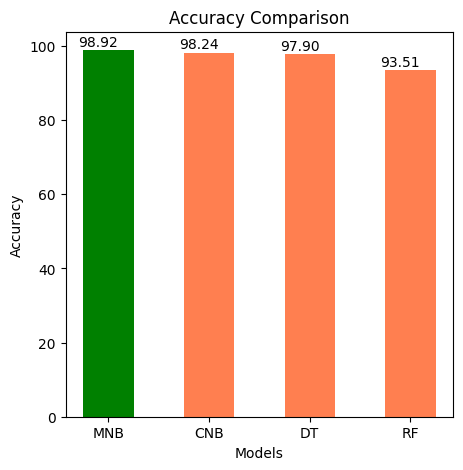

In [40]:
accuracy_dict = {'MNB': 98.92, 'CNB': 98.24, 'DT': 97.90, 'RF': 93.51}
models = list(accuracy_dict.keys())
accuracies = list(accuracy_dict.values())

fig = plt.figure(figsize=(5, 5))

# Find the index of the highest accuracy
max_accuracy_index = accuracies.index(max(accuracies))

# Bar plot with the highest accuracy bar in green
bars = plt.bar(models, accuracies, color=['green' if i == max_accuracy_index else 'coral' for i in range(len(models))], width=0.5)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")

# Add accuracy values on top of the bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 1, f'{accuracy:.2f}', ha='center', fontsize=10)

plt.show()

The MultinomialNB model achieved the highest accuracy among the evaluated models, with an accuracy score of 98.92%.

---